In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K #k for sampling#Bernouli
from keras import objectives
import pandas as pd
train=pd.read_csv("../input/mnist_train.csv")
train=train.drop(labels=['label'],axis=1) #unsupervised learning model

In [92]:
#construct encoder
x = Input(batch_shape=(100, 28*28))
h = Dense(units=256,activation='relu')(x)
#2 variables to encode
z_m=Dense(2)(h) #layers that output 0 or 1
z_log=Dense(2)(h) #layers that output 0 or 1
print (z_m,z_log)

Tensor("dense_37/BiasAdd:0", shape=(100, 2), dtype=float32) Tensor("dense_38/BiasAdd:0", shape=(100, 2), dtype=float32)


In [93]:
#sample m & log to z # Bernouli's expansion
def sampling(args):
    z_m,z_log=args
    epsilon=K.random_normal(shape=(100,2), mean=0.)
    return z_m + K.exp(z_log / 2) * epsilon
z = Lambda(sampling, output_shape=(2,))([z_m, z_log]) #lambda is a layer here
print(z)

Tensor("lambda_7/add:0", shape=(100, 2), dtype=float32)


In [94]:
#fed this z to decoder
decoder=Dense(256,activation='relu')
decoder_l=Dense(28*28,activation='sigmoid')
decoder_h=decoder(z)   #made seperate because ERROR:Tensor object not callable
x_decoded=decoder_l(decoder_h)
x_decoded#its output (decoded_mean)



<tf.Tensor 'dense_40/Sigmoid:0' shape=(100, 784) dtype=float32>

In [95]:
#loss fn--VAE(generation loss(actual loss in output)+ regularization(same samples must be closer))
def vae(x, x_decoded):
    generation_loss = 784 * objectives.binary_crossentropy(x, x_decoded)
    regularization_loss = - 0.5 * K.sum(1 + z_log - K.square(z_m) - K.exp(z_log), axis=-1)
    return generation_loss + regularization_loss


In [96]:
model=Model(x,x_decoded) #whole model's input is x and output=decoded image
model.compile(optimizer="rmsprop",loss=vae) #sgd gives irrelevant results
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (100, 784)           0                                            
__________________________________________________________________________________________________
dense_36 (Dense)                (100, 256)           200960      input_26[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense)                (100, 2)             514         dense_36[0][0]                   
__________________________________________________________________________________________________
dense_38 (Dense)                (100, 2)             514         dense_36[0][0]                   
__________________________________________________________________________________________________
lambda_7 (

In [97]:
train=train.astype('float32') / 255.
train=train.values.reshape((len(train), np.prod(train.shape[1:])))
print(train.shape)
model.fit(train,train,shuffle=True,epochs=100,batch_size=100,validation_split=0.5,verbose=1) #train-train

(60000, 784)
Train on 30000 samples, validate on 30000 samples
Epoch 1/100
30000/30000 [==============================] - 4s 120us/step - loss: 205.9361 - val_loss: 179.3053
Epoch 2/100
30000/30000 [==============================] - 3s 105us/step - loss: 175.4200 - val_loss: 172.8809
Epoch 3/100
30000/30000 [==============================] - 3s 105us/step - loss: 171.2191 - val_loss: 169.5997
Epoch 4/100
30000/30000 [==============================] - 3s 105us/step - loss: 169.0910 - val_loss: 168.1875
Epoch 5/100
30000/30000 [==============================] - 3s 104us/step - loss: 167.6437 - val_loss: 167.2732
Epoch 6/100
30000/30000 [==============================] - 3s 105us/step - loss: 166.4761 - val_loss: 166.0909
Epoch 7/100
30000/30000 [==============================] - 3s 104us/step - loss: 165.4152 - val_loss: 165.2817
Epoch 8/100
30000/30000 [==============================] - 3s 104us/step - loss: 164.5244 - val_loss: 164.2310
Epoch 9/100
30000/30000 [========================

30000/30000 [==============================] - 3s 104us/step - loss: 149.8988 - val_loss: 153.5879
Epoch 74/100
30000/30000 [==============================] - 3s 104us/step - loss: 149.8516 - val_loss: 153.3080
Epoch 75/100
30000/30000 [==============================] - 3s 105us/step - loss: 149.7482 - val_loss: 153.6227
Epoch 76/100
30000/30000 [==============================] - 3s 106us/step - loss: 149.6596 - val_loss: 153.6594
Epoch 77/100
30000/30000 [==============================] - 3s 103us/step - loss: 149.6484 - val_loss: 153.4176
Epoch 78/100
30000/30000 [==============================] - 3s 105us/step - loss: 149.5590 - val_loss: 153.3345
Epoch 79/100
30000/30000 [==============================] - 3s 105us/step - loss: 149.5338 - val_loss: 153.3136
Epoch 80/100
30000/30000 [==============================] - 3s 104us/step - loss: 149.4420 - val_loss: 153.1791
Epoch 81/100
30000/30000 [==============================] - 3s 104us/step - loss: 149.3987 - val_loss: 153.2345
Epoch

In [98]:
#encoder
test=pd.read_csv("../input/mnist_test.csv")
test=test.drop(labels=['label'],axis=1)
test=test.astype('float32') / 255.
test=test.values.reshape((len(test),np.prod(test.shape[1:])))
encoder=Model(x,z_m)
p_e=encoder.predict(test,batch_size=100)
p_e


array([[-0.43373856, -2.6287324 ],
       [ 0.3371307 ,  0.04389697],
       [-3.4822607 ,  0.7562606 ],
       ...,
       [-0.7114208 , -1.406533  ],
       [-0.53451204,  2.090385  ],
       [ 1.1166278 ,  1.0902095 ]], dtype=float32)

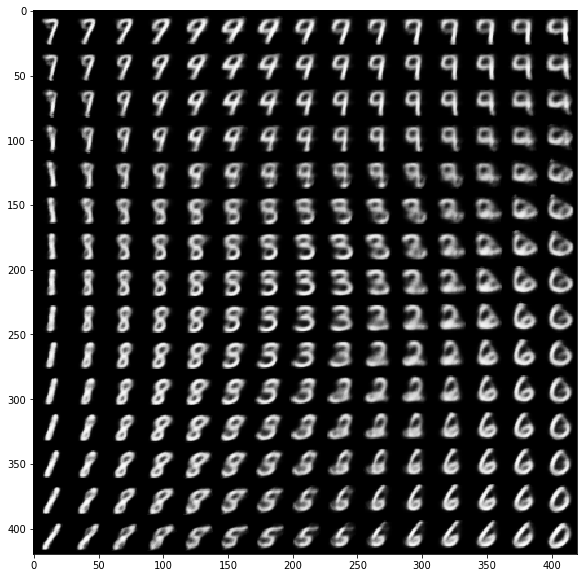

In [99]:
#CODE JUST TO SHOW 
# build a digit generator that can sample from the learned distribution# build 
input = Input(shape=(2,))
_h_decoded = decoder(input)
_x_decoded_mean = decoder_l(_h_decoded)
generator = Model(input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()